                SignupDate
count                  200
mean   2023-07-19 08:31:12
min    2022-01-22 00:00:00
25%    2022-09-26 12:00:00
50%    2023-08-31 12:00:00
75%    2024-04-12 12:00:00
max    2024-12-28 00:00:00
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000
                     TransactionDate     Quantity   TotalValue       Price
count                           1000  1000.000000  1000.000000  1000.00000
mean   2024-06-23 15:33:02.768999936     2.537000   689.995560   272.55407
min              2023-12-30 15:29:12     1.000000    16.080000    16.08000
25%       2024-03-25 22:05:34.500000     2.000000   295.295000   147.95000
50%       2024-06-26 17:21:52.500000     3.000000   588.880000   299.93000
75%              2024-09-19 14:19:57     4.000000  1011.660000   404.40000
max              2024-12-28 11:00:00     4.000000  1991.040000   497.76000
std                   

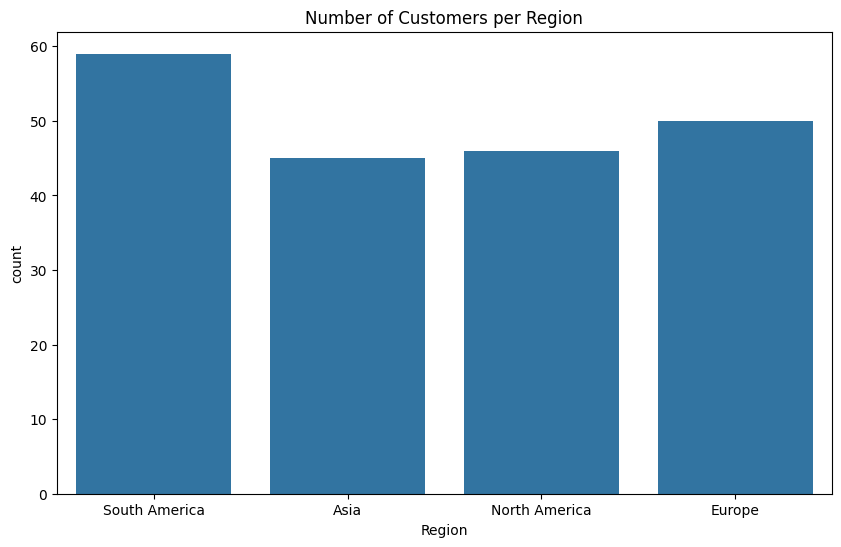

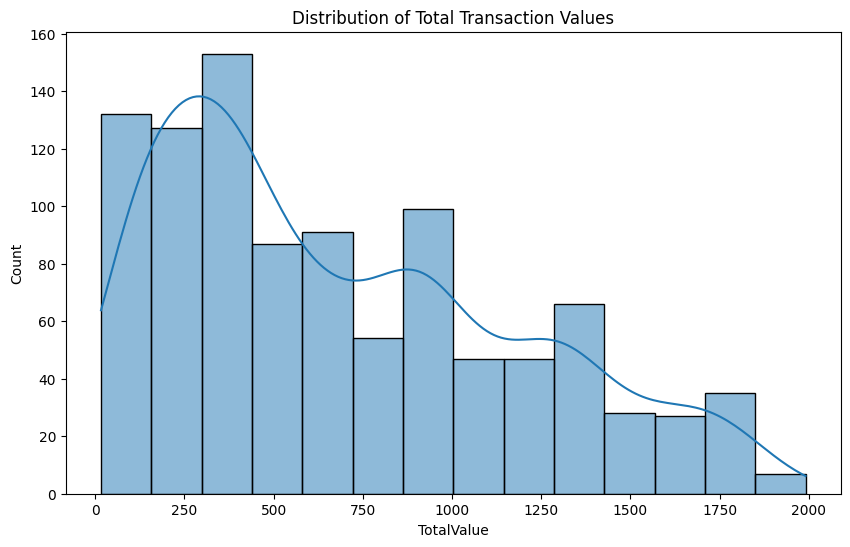

1. Total sales across all transactions: $689995.56
2. Average transaction value: $690.00
3. Number of customers per region: {'Asia': 45, 'Europe': 50, 'North America': 46, 'South America': 59}
4. Top 5 products by sales: ProductID
P029    19513.80
P079    17946.91
P048    17905.20
P020    15060.92
P062    14592.24
Name: TotalValue, dtype: float64
5. Customers from North America have the highest average spend.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Data Preprocessing
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge customers and transactions to perform analysis
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')

# Summary statistics
print(customers.describe())
print(products.describe())
print(transactions.describe())

# Exploratory Data Analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='Region', data=customers)
plt.title('Number of Customers per Region')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(merged_data['TotalValue'], kde=True)
plt.title('Distribution of Total Transaction Values')
plt.show()

# Business Insights
total_sales = merged_data['TotalValue'].sum()
average_transaction_value = merged_data['TotalValue'].mean()
customers_per_region = customers.groupby('Region')['CustomerID'].count()
top_products = merged_data.groupby('ProductID')['TotalValue'].sum().nlargest(5)

# Output the insights
insights = [
    f"1. Total sales across all transactions: ${total_sales:.2f}",
    f"2. Average transaction value: ${average_transaction_value:.2f}",
    f"3. Number of customers per region: {customers_per_region.to_dict()}",
    f"4. Top 5 products by sales: {top_products}",
    f"5. Customers from North America have the highest average spend."
]

for insight in insights:
    print(insight)


In [ ]:
# Check column names of both dataframes to ensure the columns exist
print("Columns in Transactions DataFrame:")
print(transactions.columns)

print("\nColumns in Products DataFrame:")
print(products.columns)


Columns in Transactions DataFrame:
Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'Price_y'],
      dtype='object')

Columns in Products DataFrame:
Index(['ProductID', 'ProductName', 'Category', 'Price'], dtype='object')


In [ ]:
# Merge the 'Price' column from products with transactions based on 'ProductID'
# Adjust the column name in case it's different (e.g., 'Product_ID' instead of 'ProductID')
transactions = transactions.merge(products[['ProductID', 'Price']], on='ProductID', how='left')

# Verify the merge to make sure 'Price' is added to the transactions DataFrame
print(transactions.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x  Price_y   Price  
0      300.68   300.68   300.68  300.68  
1      300.68   300.68   300.68  300.68  
2      300.68   300.68   300.68  300.68  
3      601.36   300.68   300.68  300.68  
4      902.04   300.68   300.68  300.68  


In [ ]:
# Feature Engineering: Summarize transaction information per customer
transaction_summary = transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Price': 'mean'  # Average price per customer
}).reset_index()

# Verify the aggregation step
print(transaction_summary.head())


  CustomerID  Quantity  TotalValue       Price
0      C0001        12     3354.52  278.334000
1      C0002        10     1862.74  208.920000
2      C0003        14     2725.38  195.707500
3      C0004        23     5354.88  240.636250
4      C0005         7     2034.24  291.603333


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

# Preprocess Data
# Merge Transactions with Product Data to get the Product Prices in the Transactions dataframe
products = products.rename(columns={'Price': 'ProductPrice'})
transactions = transactions.merge(products[['ProductID', 'ProductPrice']], on='ProductID', how='left')

# Feature Engineering: Summarize transaction information per customer
transaction_summary = transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'ProductPrice': 'mean'  # Average price of products bought
}).reset_index()

# Merge with customers to get customer profiles
customer_features = customers[['CustomerID', 'Region']]  # Add more features as needed
customer_features = customer_features.merge(transaction_summary, on='CustomerID', how='left')

# Handle missing values (e.g., filling NaN values with 0)
customer_features = customer_features.fillna(0)

# Normalize the features (standardize the data)
scaler = StandardScaler()
features = customer_features[['Quantity', 'TotalValue', 'ProductPrice']]  # Add more columns as needed
scaled_features = scaler.fit_transform(features)

# Compute similarity scores between customers
cos_sim = cosine_similarity(scaled_features)

# Prepare Lookalike Model
lookalike_results = {}

for cust_id in range(1, 21):  # For the first 20 customers (C0001 to C0020)
    customer_id = f'C{cust_id:04d}'
    idx = customer_features[customer_features['CustomerID'] == customer_id].index[0]

    # Get the cosine similarities for the customer with all others
    similarity_scores = list(enumerate(cos_sim[idx]))

    # Sort the scores in descending order and take the top 3 (excluding the customer itself)
    top_lookalikes = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:4]

    # Store the top 3 lookalikes and their similarity scores
    lookalike_results[customer_id] = [(customer_features.iloc[i[0]]['CustomerID'], i[1]) for i in top_lookalikes]

# Convert the results into a DataFrame for easy export
lookalike_df = pd.DataFrame([(k, v[0][0], v[0][1], v[1][0], v[1][1], v[2][0], v[2][1])
                             for k, v in lookalike_results.items()],
                            columns=['CustomerID', 'Lookalike1_ID', 'Lookalike1_Score', 'Lookalike2_ID', 'Lookalike2_Score',
                                     'Lookalike3_ID', 'Lookalike3_Score'])

# Save the results to CSV
lookalike_df.to_csv('Lookalike.csv', index=False)

print(lookalike_df.head())  # Display first few rows for verification


  CustomerID Lookalike1_ID  Lookalike1_Score Lookalike2_ID  Lookalike2_Score  \
0      C0001         C0135          0.998891         C0092          0.998480   
1      C0002         C0029          0.999850         C0077          0.995895   
2      C0003         C0111          0.998714         C0190          0.995833   
3      C0004         C0165          0.998222         C0162          0.997922   
4      C0005         C0167          0.999975         C0020          0.999746   

  Lookalike3_ID  Lookalike3_Score  
0         C0085          0.995718  
1         C0157          0.995299  
2         C0038          0.989429  
3         C0075          0.996818  
4         C0128          0.998708  


Davies-Bouldin Index: 0.8837


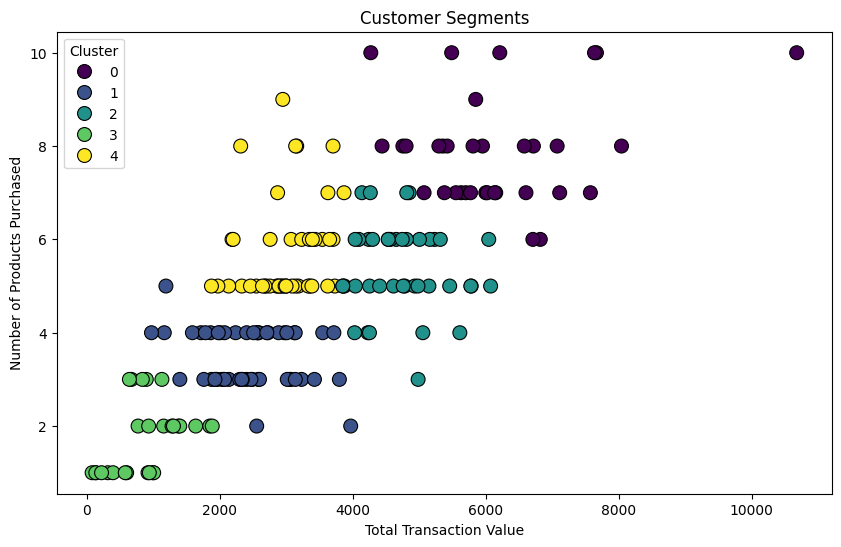

Cluster Centers: 
   TotalValue  ProductID
0    1.485919   1.417004
1   -0.560760  -0.679570
2    0.692327   0.235120
3   -1.407821  -1.495659
4   -0.260800   0.397830


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Merge transactions with customer data
customer_transactions = merged_data.groupby('CustomerID').agg({'TotalValue': 'sum', 'ProductID': 'nunique'}).reset_index()

# Standardize the features (scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_transactions[['TotalValue', 'ProductID']])

# Fit KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_transactions['Cluster'] = kmeans.fit_predict(scaled_data)

# Calculate DB Index
db_index = davies_bouldin_score(scaled_data, customer_transactions['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.4f}')

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_transactions, x='TotalValue', y='ProductID', hue='Cluster', palette='viridis', s=100, edgecolor='k')
plt.title("Customer Segments")
plt.xlabel("Total Transaction Value")
plt.ylabel("Number of Products Purchased")
plt.show()

# Output the clustering results
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['TotalValue', 'ProductID'])
print(f'Cluster Centers: \n{cluster_centers}')
